# Off-Policy Reinforcement Learning with Value Function Approximation

In [1]:
import numpy as np
import tqdm
import lqg1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from utils import collect_episodes, estimate_performance

### Experiments parameters

In [2]:
env = lqg1d.LQG1D(initial_state_type='random')
discount = 0.9
horizon = 50
n_itr = 50
lmbd = 0.1 

theta_ = np.zeros((3,))
actions = discrete_actions = np.linspace(-8, 8, 20)

### Show the optimal Q-function

In [3]:
def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T

Optimal K: [[-0.58840335]] Covariance S: 0.001


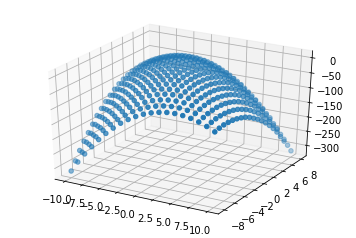

In [4]:
states = discrete_states = np.linspace(-10, 10, 20)
SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

K, cov = env.computeOptimalK(discount), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

Q_opt = Q_fun(SA)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)

plt.show()

In [5]:
def phi(s, a):
    return np.array([a, s * a, s * s + a * a])

In [6]:
def Fitted_QIteration(beh_policy, fqi, n_itr, horizon,lmbd):
    dataset = collect_episodes(env, n_episodes=100, policy=beh_policy, horizon=horizon)
    J = []
    for t in range(n_itr):
        Z = np.zeros((horizon, 3))
        Y = np.zeros(horizon)
        for i in range(horizon):
            Z[i] = phi(dataset[t]['states'][i], dataset[t]['actions'][i])
            Y[i] = dataset[t]['rewards'][i] + discount * np.max(
                [phi(dataset[t]['next_states'][i], a_).dot(fqi.theta) for a_ in actions])
        fqi.theta = np.linalg.inv(np.transpose(Z).dot(Z) + lmbd * np.identity(3)).dot(np.transpose(Z)).dot(Y)
        J.append(estimate_performance(env, policy=fqi, horizon=horizon, n_episodes=100, gamma=discount))
    return J, fqi.theta

### Collect the samples using the behavioural policy

In [7]:
class beh_policy(object):
    def __init__(self, a):
        self.actions = a

    def draw_action(self, s):
        return self.actions[np.random.randint(len(self.actions))]


class FQI_policy(object):
    def __init__(self, a, t):
        self.theta = t
        self.actions = a
        
    def draw_action(self, s):
        return self.actions[np.argmax([phi(s, a_).dot(self.theta) for a_ in self.actions])]

In [8]:
beh_policy = beh_policy(actions)

In [9]:
fqi_policy = FQI_policy(actions,theta_)

## Influence of Regularization

In [17]:
J_0, theta = Fitted_QIteration(beh_policy, fqi_policy, n_itr, horizon,0)

In [18]:
J_01, theta = Fitted_QIteration(beh_policy, fqi_policy, n_itr, horizon,0.1)

In [19]:
J_05, theta = Fitted_QIteration(beh_policy, fqi_policy, n_itr, horizon,0.5)

In [20]:
J_1, theta = Fitted_QIteration(beh_policy, fqi_policy, n_itr, horizon,1)

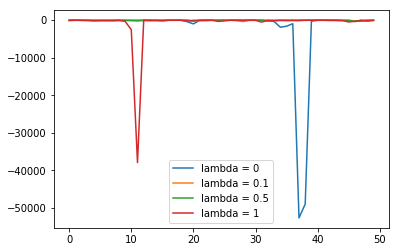

In [21]:
plt.plot(J_0, label = "lambda = 0")
plt.plot(J_01, label = "lambda = 0.1")
plt.plot(J_05, label = "lambda = 0.5")
plt.plot(J_1, label = "lambda = 1")
plt.legend()
plt.show()

As we can see, regularization has an impact on J, it is not totally clear in this image but with different tests we can conclude that we should not take a too high (>1) or too low (arround 0)lambda to have correct results.

## Influence of Number of iterations

###  One iteration

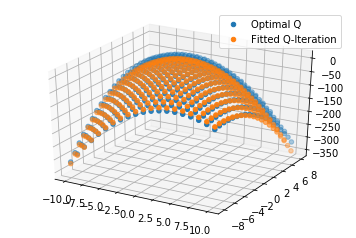

Error (Frobenius): 222.055899479


In [22]:
J, theta = Fitted_QIteration(beh_policy, fqi_policy, 1, horizon,lmbd)

Q_ = np.zeros((len(states),len(actions)))
for i in range(len(states)):
    for j in range(len(actions)):
        Q_[i,j] = phi(states[i],actions[j]).dot(theta)
Q_ = Q_.reshape(400)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt, label="Optimal Q")
ax.scatter(S, A, Q_, label="Fitted Q-Iteration")
ax.legend()
plt.show()

print("Error (Frobenius):",np.linalg.norm(Q_opt-Q_))

###  10 iterations

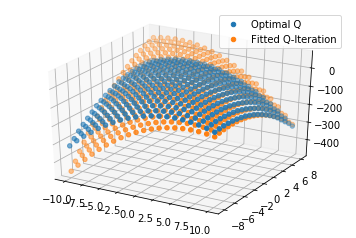

Error (Frobenius): 1021.19684608


In [23]:
J, theta = Fitted_QIteration(beh_policy, fqi_policy, 10, horizon,lmbd)

Q_ = np.zeros((len(states),len(actions)))
for i in range(len(states)):
    for j in range(len(actions)):
        Q_[i,j] = phi(states[i],actions[j]).dot(theta)
Q_ = Q_.reshape(400)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt, label="Optimal Q")
ax.scatter(S, A, Q_, label="Fitted Q-Iteration")
ax.legend()
plt.show()

print("Error (Frobenius):",np.linalg.norm(Q_opt-Q_))

###  50 iterations

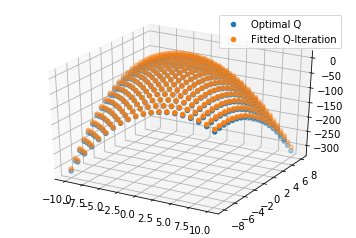

Error (Frobenius): 97.2913473759


In [24]:
J, theta = Fitted_QIteration(beh_policy, fqi_policy, 50, horizon,lmbd)

Q_ = np.zeros((len(states),len(actions)))
for i in range(len(states)):
    for j in range(len(actions)):
        Q_[i,j] = phi(states[i],actions[j]).dot(theta)
Q_ = Q_.reshape(400)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt, label="Optimal Q")
ax.scatter(S, A, Q_, label="Fitted Q-Iteration")
ax.legend()
plt.show()

print("Error (Frobenius):",np.linalg.norm(Q_opt-Q_))

As excpected, the results improve when the number of iterations increases. The error decreases and the representations (Optimal and Fitted) are closer as we can see in the 3D graphs. 